# Alpaca Hum Segmentation – Per-tape Insights

**Notebook goal** – Load `metrics_per_tape.csv` produced by `evaluate_benchmark.py` and explore model performance variability *across individual tapes*:

* Distribution of F1 / precision / recall per model
* Heat-map of F1 (<code>tape × variant</code>)
* Precision–Recall scatter (one marker = one <code>model, variant, tape</code>)
* Boundary-error (Δstart/Δend) distributions per model
* Identify the hardest and easiest tapes

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [2]:
# ⇩ adjust to wherever you saved the file produced by evaluate_benchmark.py
METRICS_CSV = Path("/Users/danie/repos/alpaca-segmentation/BENCHMARK/metrics_per_tape.csv")
assert METRICS_CSV.exists(), f"{METRICS_CSV} not found"

In [3]:
df = pd.read_csv(METRICS_CSV)

def parse_variant_tag(tag: str):
    """Return seq_len (s), hop (s), threshold (float) from a variant tag."""
    m = re.match(r"len(\d+)_hop(\d+)_th(\d+)", tag)
    if not m:
        return None, None, None
    seq = int(m[1]) / 1000  # back to seconds
    hop = int(m[2]) / 1000
    th  = int(m[3]) / 100
    return seq, hop, th

df[["seq_len_s", "hop_s", "threshold"]] = (
    df["variant"].apply(lambda t: pd.Series(parse_variant_tag(t)))
)

display(df.head())

,n_gt,n_pred,tp,fp,fn,precision,recall,f1,mean_dstart_ms,mean_dend_ms,...,recall_q2,f1_q2,recall_q3,f1_q3,tape,model,variant,seq_len_s,hop_s,threshold
0,1,915,1,914,0,0.001093,1.0,0.002183,295.0,275.0,...,NaN,NaN,NaN,NaN,388_20250204.wav,v6_proportional_clipwise_by_tape,len400_hop050_th50,0.4,0.05,0.5
1,0,693,0,693,0,0.000000,0.0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,388_20250204_2nd_Obs.wav,v6_proportional_clipwise_by_tape,len400_hop050_th50,0.4,0.05,0.5
2,7,620,0,620,7,0.000000,0.0,0.000000,NaN,NaN,...,0.0,NaN,NaN,NaN,4212_20250205.wav,v6_proportional_clipwise_by_tape,len400_hop050_th50,0.4,0.05,0.5
3,1,130,1,129,0,0.007692,1.0,0.015267,291.0,228.0,...,NaN,NaN,1.0,1.0,7919_20250203.wav,v6_proportional_clipwise_by_tape,len400_hop050_th50,0.4,0.05,0.5
4,1,631,1,630,0,0.001585,1.0,0.003165,302.0,264.0,...,NaN,NaN,NaN,NaN,PINK_20250203.wav,v6_proportional_clipwise_by_tape,len400_hop050_th50,0.4,0.05,0.5


## 1 · Performance spread per model

/var/folders/yy/mfzpfh1n7vsdd7qnk0wl69700000gn/T/ipykernel_36847/1862765082.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/yy/mfzpfh1n7vsdd7qnk0wl69700000gn/T/ipykernel_36847/1862765082.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/yy/mfzpfh1n7vsdd7qnk0wl69700000gn/T/ipykernel_36847/1862765082.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


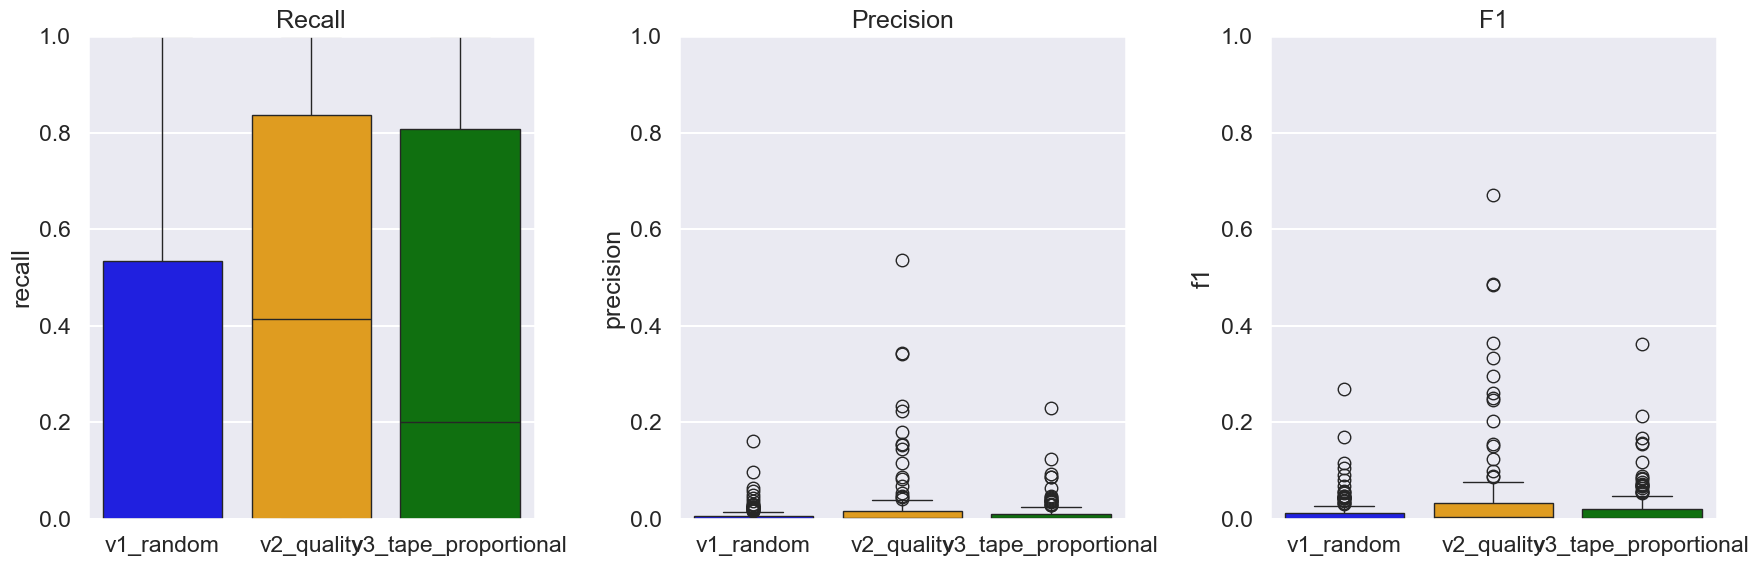

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom color palette for models
custom_palette = {
    "v1_random": "blue",
    "v2_quality": "orange",
    "v3_tape_proportional": "green",
}

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Define the order and titles
metrics = ["recall", "precision", "f1"]
titles = ["Recall", "Precision", "F1"]

for ax, metric, title in zip(axs, metrics, titles):
    sns.boxplot(
        x="model",
        y=metric,
        data=df,
        ax=ax,
        palette=custom_palette,
        order=["v1_random", "v2_quality", "v3_tape_proportional"]
    )
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 2 · F1 heat-map (tape × variant)

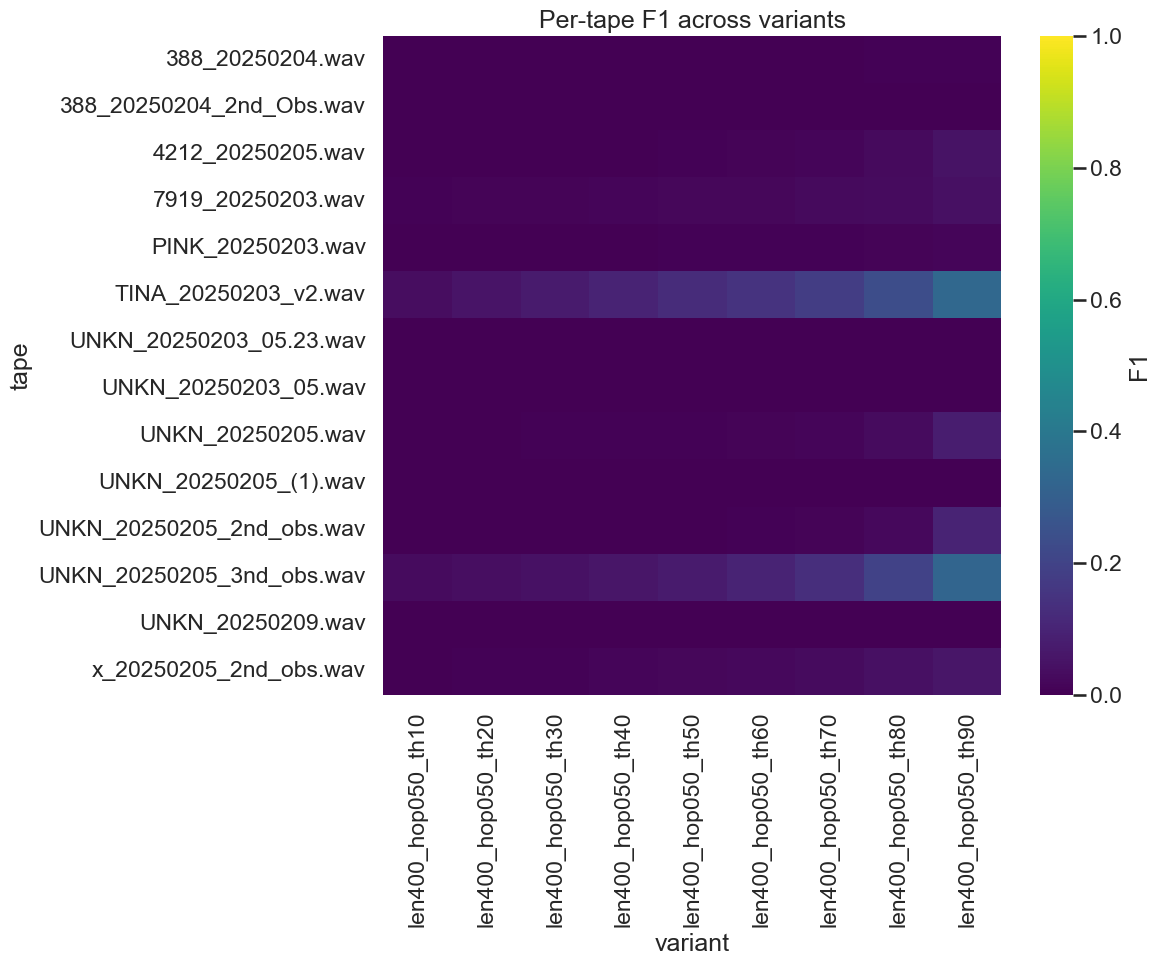

In [5]:
# This can get wide – filter or pivot as needed
pivot = df.pivot_table(index="tape", columns="variant", values="f1")

plt.figure(figsize=(max(12, 0.4 * len(pivot.columns)), max(10, 0.25 * len(pivot))))
sns.heatmap(
    pivot,
    annot=False,
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "F1"},
)
plt.title("Per-tape F1 across variants")
plt.xlabel("variant")
plt.ylabel("tape")
plt.tight_layout()
plt.show()

## 3 · Recall heat-map (tape × variant)

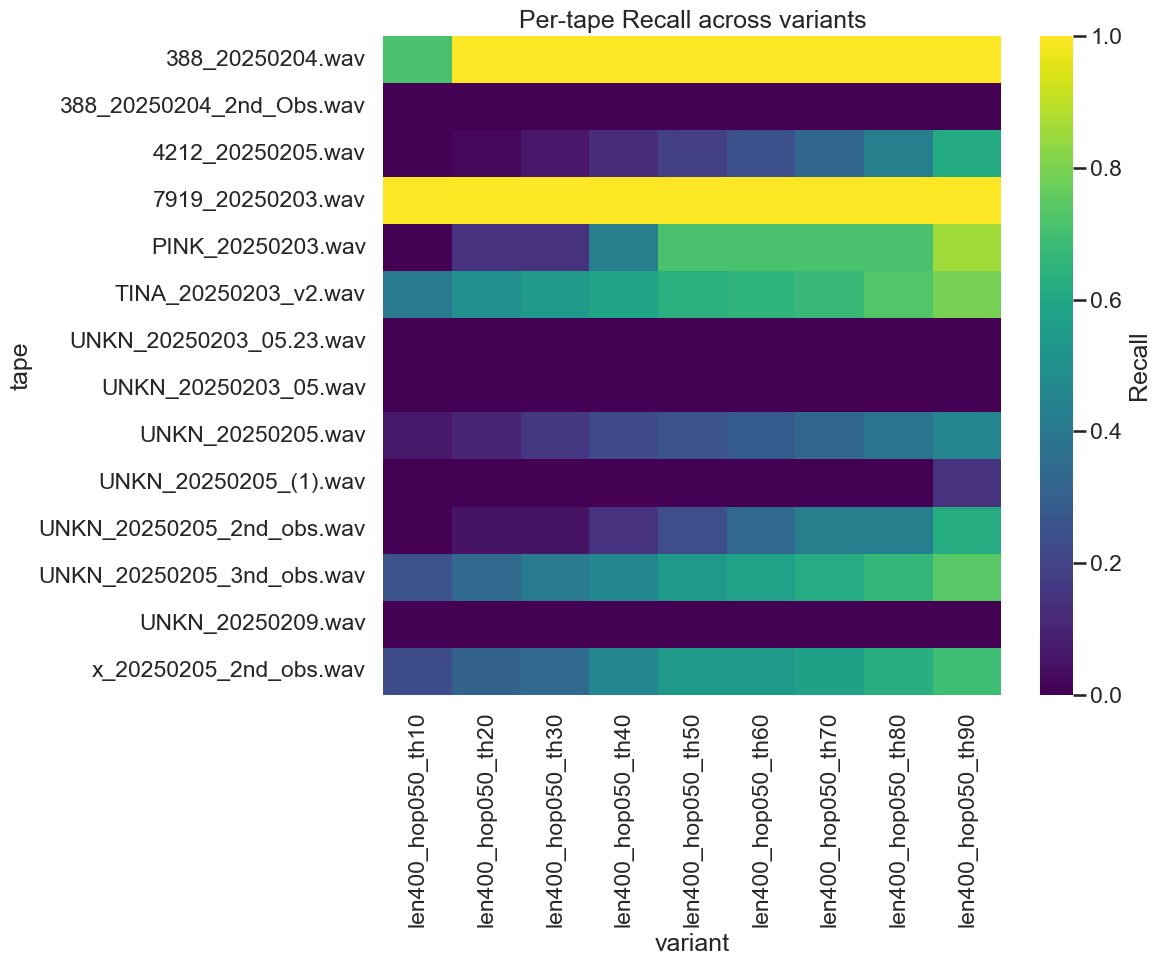

In [6]:
# This can get wide – filter or pivot as needed
pivot = df.pivot_table(index="tape", columns="variant", values="recall")

plt.figure(figsize=(max(12, 0.4 * len(pivot.columns)), max(10, 0.25 * len(pivot))))
sns.heatmap(
    pivot,
    annot=False,
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Recall"},
)
plt.title("Per-tape Recall across variants")
plt.xlabel("variant")
plt.ylabel("tape")
plt.tight_layout()
plt.show()

## 4 · Precision heat-map (tape × variant)

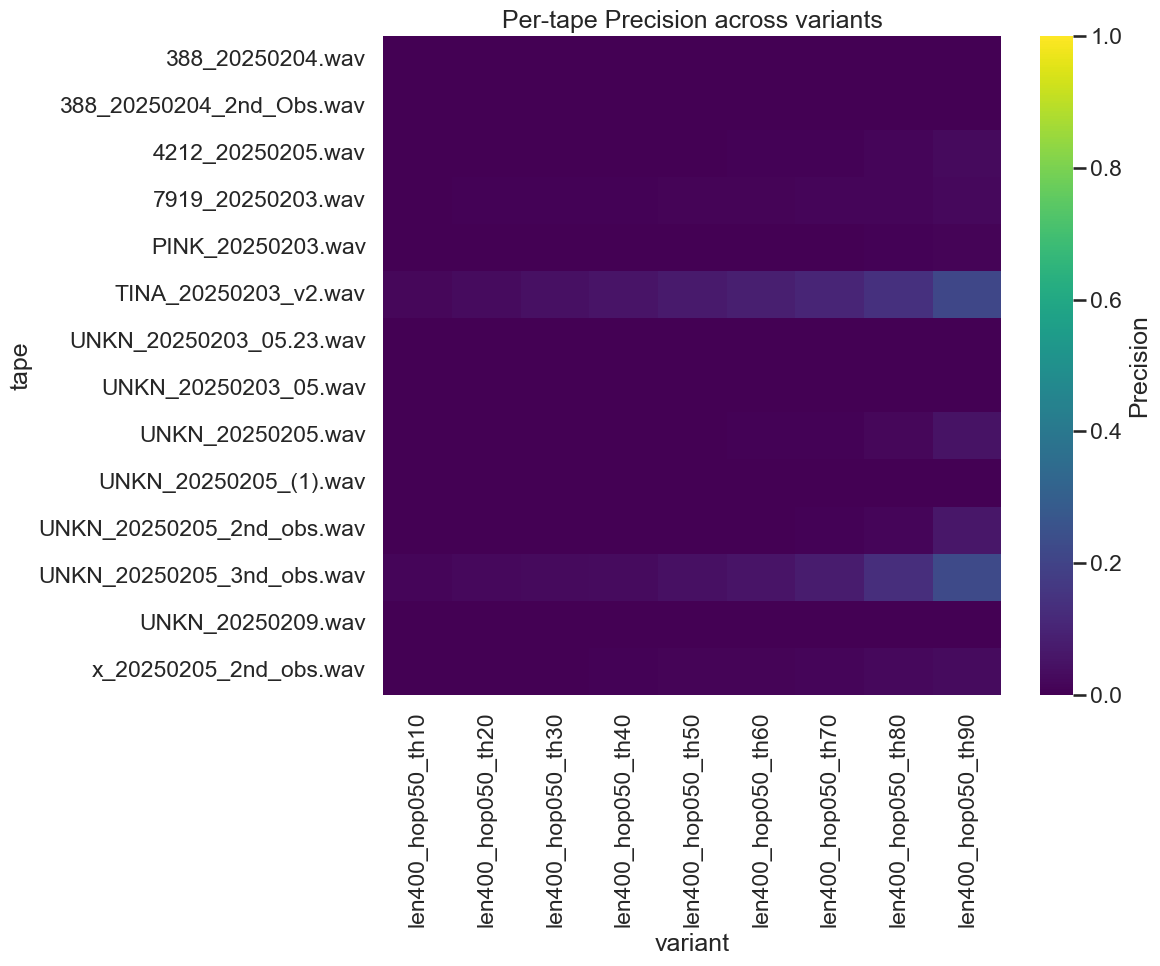

In [7]:
# This can get wide – filter or pivot as needed
pivot = df.pivot_table(index="tape", columns="variant", values="precision")

plt.figure(figsize=(max(12, 0.4 * len(pivot.columns)), max(10, 0.25 * len(pivot))))
sns.heatmap(
    pivot,
    annot=False,
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Precision"},
)
plt.title("Per-tape Precision across variants")
plt.xlabel("variant")
plt.ylabel("tape")
plt.tight_layout()
plt.show()

## 5 · Hardest & easiest tapes

In [8]:
# Mean F1 over variants for each tape – lower = harder
tape_mean = df.groupby("tape")["f1"].mean()

hardest = tape_mean.nsmallest(10)
easiest = tape_mean.nlargest(10)

print("### Hardest tapes (mean F1)\n", hardest)
print("\n### Easiest tapes (mean F1)\n", easiest)

### Hardest tapes (mean F1)
 tape
388_20250204_2nd_Obs.wav     0.000000
UNKN_20250203_05.23.wav      0.000000
UNKN_20250203_05.wav         0.000000
UNKN_20250209.wav            0.000000
UNKN_20250205_(1).wav        0.000122
388_20250204.wav             0.003067
PINK_20250203.wav            0.004731
4212_20250205.wav            0.012149
UNKN_20250205_2nd_obs.wav    0.015043
UNKN_20250205.wav            0.017212
Name: f1, dtype: float64

### Easiest tapes (mean F1)
 tape
TINA_20250203_v2.wav         0.140582
UNKN_20250205_3nd_obs.wav    0.109585
x_20250205_2nd_obs.wav       0.021269
7919_20250203.wav            0.018586
UNKN_20250205.wav            0.017212
UNKN_20250205_2nd_obs.wav    0.015043
4212_20250205.wav            0.012149
PINK_20250203.wav            0.004731
388_20250204.wav             0.003067
UNKN_20250205_(1).wav        0.000122
Name: f1, dtype: float64
